## TODO

clean names + plot title

# Project Notebook

This Notebook is done as part of a project in the course "Machine Learning in Times Series" by Laurent OURDE and has been done by Stanislas DOZIAS and Meryem JAAIDAN.

### Usefull code links:

- sktime folder with MrSEQL algorithm: https://github.com/sktime/sktime/tree/v0.8.1/sktime/classification/shapelet_based/mrseql


- original github of the paper (in c++) https://github.com/lnthach/Mr-SEQL

### What we recoded and what we didn't

The goal of this notebook is to recode the interpretable part of the paper, in a realistic time. So we recoded (by inspiring us from some C++ code):
- The SAX representation
- The plot of the discriminative regions used for interpretation (there will be some difference in the results which we can't explain)

More precisely, we didn't recode the SEQL part and its training, letting this for the already implemented `MrSEQLClassifier`.

## Imports

### WARNING: sktime version is 0.8.1

(in order to have MrSEQLClassifier: it has been removed from sktime later for compatibility purposes)

In [1]:
import string
import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sktime.classification.shapelet_based import MrSEQLClassifier # https://github.com/sktime/sktime/blob/v0.8.1/sktime/classification/shapelet_based/mrseql/mrseql.pyx
from sktime.datasets._data_io import load_from_tsfile_to_dataframe
from sktime.utils.validation.panel import check_X

## Test on paper examples for SAX representation

The goal of this part is to retrieve the SAX examples given in the paper. As we will see, there will be some surprises !


Some notations:
- `l` : window size
- `w` : word length
- `alpha` : alphabet_size

### Constant parameters

In [2]:
alpha = 4
break_points = [-0.674489750196, 0.0, 0.674489750196]

### Only 1 windows

In [3]:
def segment2SAX(timeseries, cur_pos, l, w, paper_alphabet_order = False, normalize=True, dupplicate_PAA=True):
    """
    adaptation of this code https://github.com/sktime/sktime/blob/v0.8.1/sktime/classification/shapelet_based/mrseql/sax_converter.h

    Convert a part of a timeseries (from cur_pos to cur_pos + window_size) to its SAX representation, given a window_length 'l' and a word_length 'w'.

    If 'paper_alphabet_order' is True, it uses the order of the examples in the paper, i.e 'a' for high values
    If 'normalize' is False, it doesn't normalize the window before applying PPA
    If dupplicate_PPA is True, the PAA will have the same shape as the timeseries to better comparison
    """
    # the following variable renaming is to better match both implementations
    window_size = l
    word_length = w
    alphabet_size = alpha

    window_end = cur_pos + window_size

    mean_wd = np.mean(timeseries[cur_pos:window_end])
    var_wd = np.var(timeseries[cur_pos:window_end])

    subsection = np.zeros(window_size)
    for i in range(cur_pos, window_end):
        if normalize:
            normalized_value = timeseries[i]-mean_wd
            if var_wd>0:
                normalized_value = normalized_value / np.sqrt(var_wd)
        else:
            normalized_value = timeseries[i]
        subsection[i-cur_pos] = normalized_value
        
    paa_size = window_size / word_length
    sax_word = ""
    if dupplicate_PAA:
        list_PPA = np.zeros(int(paa_size)*word_length) # added, to retrieve the PPA computed
    else:
        list_PPA = np.zeros(word_length)
    for i in range(word_length):
        bin = 0

        # This following lines are here to be able to make SAX representation
        # even if the word_length doesn't divide the window_size
        windowStartIdx = paa_size * i
        windowEndIdx = paa_size * (i + 1) - 1
        fullWindowStartIdx = int(np.ceil(windowStartIdx))
        fullWindowEndIdx = int(np.floor(windowEndIdx))
        startFraction = fullWindowStartIdx - windowStartIdx
        endFraction = windowEndIdx - fullWindowEndIdx

        aggValue = 0
        if (startFraction > 0):
            aggValue += subsection[fullWindowStartIdx - 1] * startFraction

        # 2nd condition is a safeguard against index-out-of-bounds because of
        # numerical imprecision
        if (endFraction > 0 and fullWindowEndIdx < window_size - 1) :
            aggValue += subsection[fullWindowEndIdx + 1] * endFraction
        for j in range(fullWindowStartIdx, fullWindowEndIdx+1):
            aggValue += subsection[j]
        PAA = aggValue / paa_size

        if dupplicate_PAA:
            for k in range(int(paa_size)): # added, to retrieve the PPA computed
                list_PPA[int(paa_size)*i+k] = PAA
        else:
            list_PPA[i] = PAA

        for j in range(alphabet_size-1):
            if (PAA >= break_points[j]):
                bin += 1

        if paper_alphabet_order:
            sax_word += string.ascii_lowercase[alphabet_size - bin - 1] # this is to do like in the paper
        else:
            sax_word += string.ascii_lowercase[bin] # this is what is implemented

    return sax_word, list_PPA, subsection

In [4]:
timeseries = np.array([0.323, 0.742, 0.912, 1.021, -0.044, 0.124, -0.532, 0.001])

l = timeseries.shape[0]
w = 4

As in the article: babc (i.e. not normalized and 'a' for high value)
Normalized equivalent: bacd (i.e. normalized and 'a' for high value)
As it is used in the code: cdba (i.e. normalized and 'a' for low value)


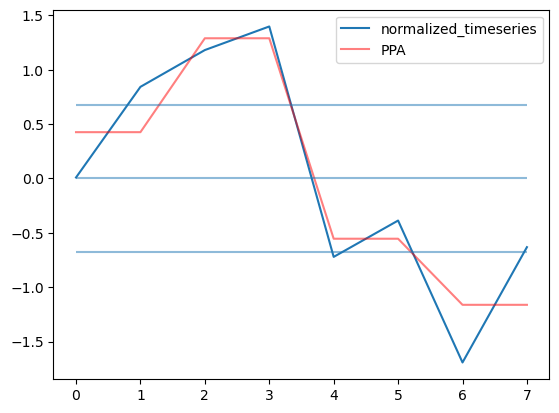

In [5]:
sax_word, list_PPA, subsection = segment2SAX(timeseries, 0, l, w, paper_alphabet_order=True, normalize=False)
print(f"As in the article: {sax_word} (i.e. not normalized and 'a' for high value)")
sax_word, list_PPA, subsection = segment2SAX(timeseries, 0, l, w, paper_alphabet_order=True, normalize=True)
print(f"Normalized equivalent: {sax_word} (i.e. normalized and 'a' for high value)")
sax_word, list_PPA, subsection = segment2SAX(timeseries, 0, l, w)
print(f"As it is used in the code: {sax_word} (i.e. normalized and 'a' for low value)")

plt.plot(subsection, label="normalized_timeseries")
plt.plot(list_PPA, alpha=0.5, color="r", label = "PPA")
plt.hlines(break_points, 0, l-1, alpha=0.5)
plt.legend()
plt.show()

To be compared with

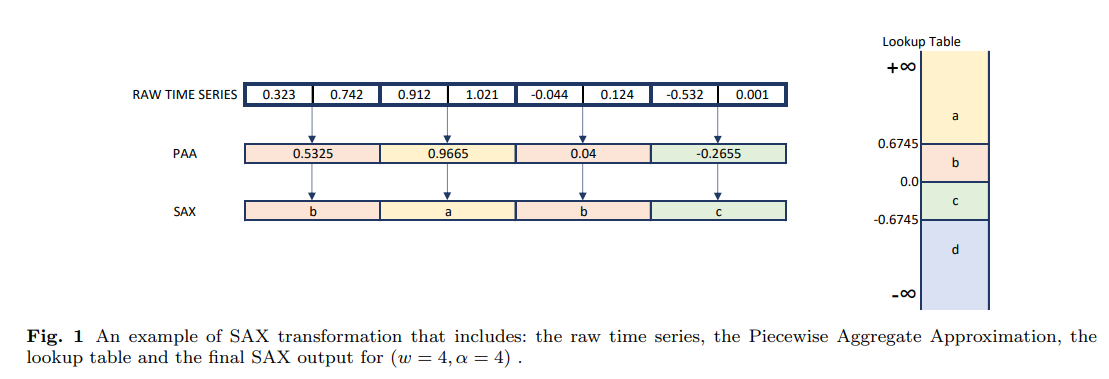

### Sliding windows

In [6]:
def timeseries2SAX(timeseries, l, w, paper_alphabet_order=False, normalize=True):
    """
    Convert a timeseries to its SAX representation, given a window_lenght 'l' and a word size 'w'.
    'paper_alphabet_order' and 'normalize' are the same parameters as in 'segment2SAX'
    """
    L = timeseries.shape[0]
    # PAA transform (and inverse transform) of the data
    list_word = []
    for cur_pos in range(L-l+1):
        sax_word, list_PPA, subsection = segment2SAX(timeseries, cur_pos, l, w, paper_alphabet_order, normalize)
        list_word.append(sax_word)
    return list_word

In [7]:
timeseries = np.array([0.323, 0.742, 0.912, 1.021, -0.044, 0.124, -0.532, 0.001, -0.343, -1.211])

l = 8
w = 4

In [8]:
list_word = timeseries2SAX(timeseries, l, w, paper_alphabet_order=True, normalize=False)
print(f"As in the article: {' '.join(list_word)} (i.e. not normalized and 'a' for high value)")
list_word = timeseries2SAX(timeseries, l, w, paper_alphabet_order=True, normalize=True)
print(f"Normalized equivalent: {' '.join(list_word)} (i.e. normalized and 'a' for high value)")
list_word = timeseries2SAX(timeseries, l, w)
print(f"As it is used in the code: {' '.join(list_word)} (i.e. normalized and 'a' for low value)")

As in the article: babc abcc abcd (i.e. not normalized and 'a' for high value)
Normalized equivalent: bacd abdd abcd (i.e. normalized and 'a' for high value)
As it is used in the code: cdba dcaa dcba (i.e. normalized and 'a' for low value)


To compare with

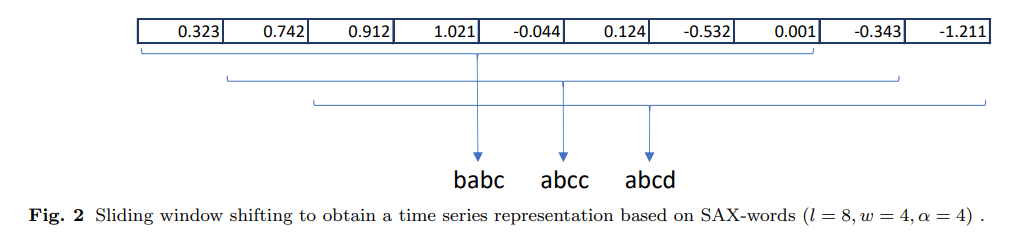

### Conclusion of these comparisons

The SAX examples in the paper are wrong because the normalization isn't done.

Furthermore, as we will see in the next part, the order for the symbols are also inversed, with 'a' for low value (and not high values like in the paper examples).

## GunPoint dataset

This is the same dataset as in the paper example, the goal here is to retrieve their results.

### Data loading and examples

We need to download by hand the time series from https://timeseriesclassification.com/ and load them with the good path.

This is because we took the version 0.8.1 of sktime in order to have MR_SEQL algorithm.

In [9]:
DATA_PATH = os.path.join("./../data/Univariate_ts/")

dataset_name = "GunPoint"

class_dict = {"1": "Gun", "2": "Point"}
label_dict = {"1": 0, "2": 1} # for plotting purpose

X_train, y_train = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TRAIN.ts")
)
X_test, y_test = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TEST.ts")
)

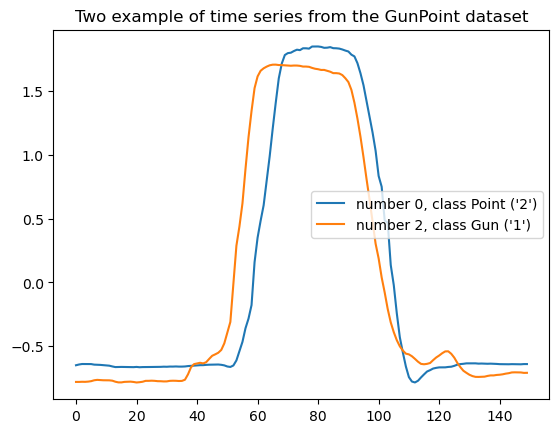

In [10]:
# An example of 2 timeseries from this dataset

i, j = 0, 2
plt.plot(X_train["dim_0"][i], label=f"number {i}, class {class_dict[y_train[i]]} ('{y_train[i]}')")
plt.plot(X_train["dim_0"][j], label=f"number {j}, class {class_dict[y_train[j]]} ('{y_train[j]}')")
plt.title(f"Two example of time series from the {dataset_name} dataset")
plt.legend()
plt.show()

### Set the config and train the classifier

In [11]:
L = X_train["dim_0"][0].shape[0]

w = 16

list_l = list(range(20, L, 11)) # list of l used in the article, doesn't follows their own rules ([w, w+int(sqrt(L)), ...] = [16, 16+sqrt(150), ...] = [16, 28, ...])

custom_config = []
for i in range(len(list_l)):
    custom_config.append({'method': 'sax', 'window': list_l[i], 'word': w, 'alphabet': alpha})

In [12]:
clf = MrSEQLClassifier(seql_mode="fs", symrep=('sax'), custom_config=custom_config)
clf.fit(X_train, y_train)
print(f"test score: {clf.score(X_test, y_test)}")

test score: 0.9866666666666667


### Check that our sax representation is coherent with the clf one

This is to show that the order of the clf is not the same than the one used in the examples in the article.

Like expected, the difference appears when there are two consecutive equal words (the clf deletes consecutive redundancy for numerical reduction), which we do not because we want all words for interpretability purposess !

In [13]:
num_l = 0
num_data = 0
l, w = custom_config[num_l]["window"], custom_config[num_l]["word"]
timeseries = X_train["dim_0"][num_data]

# Get our words
list_word = timeseries2SAX(timeseries, l, w, paper_alphabet_order=False) # we emphasize the False here, even if it's the default value

# Get the words given by the clf
X = check_X(X_train, coerce_to_numpy=True)
list_word_clf = clf._transform_time_series(X)[num_l][num_data].decode("utf-8").split(' ')

# Compare the words one by one
print("Our words".ljust(w), "clf words")
previous_word = ""
for word, clf_word in zip(list_word, list_word_clf):
    print(word, clf_word)

    if word != clf_word:
        print()
        print("difference detected")
        print(f"previous_word: {previous_word}, last_word: {word}")
        print(f"previous and last_word are equal: {previous_word == word}")
        break

    if previous_word == word: # this should never happend, unless word != clf_word, which is caught by previous 'if'
        raise ValueError
    previous_word = word

Our words        clf words
cdddddcccbaaaaaa cdddddcccbaaaaaa
ddddddccbaaaaaaa ddddddccbaaaaaaa
dddddcccbaaaaaaa dddddcccbaaaaaaa
dddddccbaaaaaaaa dddddccbaaaaaaaa
dddddcbaaaaaaaaa dddddcbaaaaaaaaa
dddddcbabaaaaaaa dddddcbabaaaaaaa
ddddcbbbbaabaaab ddddcbbbbaabaaab
ddddbbbbbbbabbbb ddddbbbbbbbabbbb
dddcbbbbbbbbbbbb dddcbbbbbbbbbbbb
dddbbbbbbbbbbbbb dddbbbbbbbbbbbbb
ddcbbbbbbabbbbbc ddcbbbbbbabbbbbc
dcbbbbbbabbbbbcc dcbbbbbbabbbbbcc
dbcbaabaabbbbddd dbcbaabaabbbbddd
bcbabbaaabbbdddd bcbabbaaabbbdddd
bbbbabaabbbcdddd bbbbabaabbbcdddd
bbaabaabbbbddddd bbaabaabbbbddddd
baabaaabbbccdddd baabaaabbbccdddd
aabaaabbbccddddd aabaaabbbccddddd
aaaaaabbbccddddd aaaaaabbbccddddd
aaaaabbbcccdccdd aaaaabbbcccdccdd
aaaaaabbbccccddd aaaaaabbbccccddd
aaaaabbbcccbcddd aaaaabbbcccbcddd
aaaaabbbbbbbdddd aaaaabbbbbbbdddd
aaaaabbbbbbcdddd aaaaabbbbbbcdddd
aaaabbbbbbccdddd aaaabbbbbbccdddd
aaaaabbbbbccdddd aaaaabbbbbccdddd
aaaabbbabccddddd aaaabbbabccddddd
aaaaaaaabccddddd aaaaaaaabccddddd
aaaaaaabbcdddddd aaaa

### Find the most important sequences

The goal here is to retrieve to most important sequences found by the different SEQL algorithms (1 for each windows size l).


Vocabular point : all the words has the same size (16), but the sequences (i.e. features) are subwords, so they have different sizes (but <16).


The compute of the thresholds is here to retrieve th good `l` from its index in the coeffs of the clf.

In [14]:
coeffs = clf.ots_clf.coef_[0]

thresholds = [0]
cum_sum = 0
for sequence_l in clf.sequences:
    cum_sum += len(sequence_l)
    thresholds.append(cum_sum)
print(thresholds)

[0, 70, 137, 202, 259, 317, 386, 458, 494, 532, 569, 616, 666]


In [15]:
def find_l(thresholds, ind):
    """
    Given a list of thresholds, retrieve the number of the interval where ind is,
    and the distance to the begining of the found interval
    """
    for num_l in range(len(list_l)):        
        if thresholds[num_l] <= ind < thresholds[num_l+1]:
            return num_l, ind-thresholds[num_l]

In [16]:
nb_sequences_to_show = 10
print("l".ljust(3), "Coefficients".rjust(8), "Sequences")

## Get the most positive coefficients
sorted_pos_sequences_idx = coeffs.argsort()[::-1]
for ind in sorted_pos_sequences_idx[:nb_sequences_to_show//2]:
    coeff = coeffs[ind]
    num_l, num_seq = find_l(thresholds, ind)
    seq = clf.sequences[num_l][num_seq].decode("utf-8") # sequence of interest
    l = list_l[num_l] #l of interest

    print(str(l).ljust(3), str("{:.3f}".format(coeff)).rjust(12), seq)

print()

## Get the most negative coefficients
sorted_neg_sequences_idx = coeffs.argsort()
for ind in sorted_neg_sequences_idx[:nb_sequences_to_show//2][::-1]:
    coeff = coeffs[ind]
    num_l, num_seq = find_l(thresholds, ind)
    seq = clf.sequences[num_l][num_seq].decode("utf-8") # sequence of interest
    l = list_l[num_l] #l of interest
    print(str(l).ljust(3), str("{:.3f}".format(coeff)).rjust(12), seq)


l   Coefficients Sequences
42         0.033 cbaab
53         0.031 ddddb
42         0.030 da
53         0.030 db
31         0.029 daa

42        -0.031 aaaaaaabbcdddddd
53        -0.031 bbbcddddd
53        -0.032 bbbbbbbaaa
20        -0.033 bbbbaaaaaa
53        -0.034 bbbbbbaaa


To be compared with:

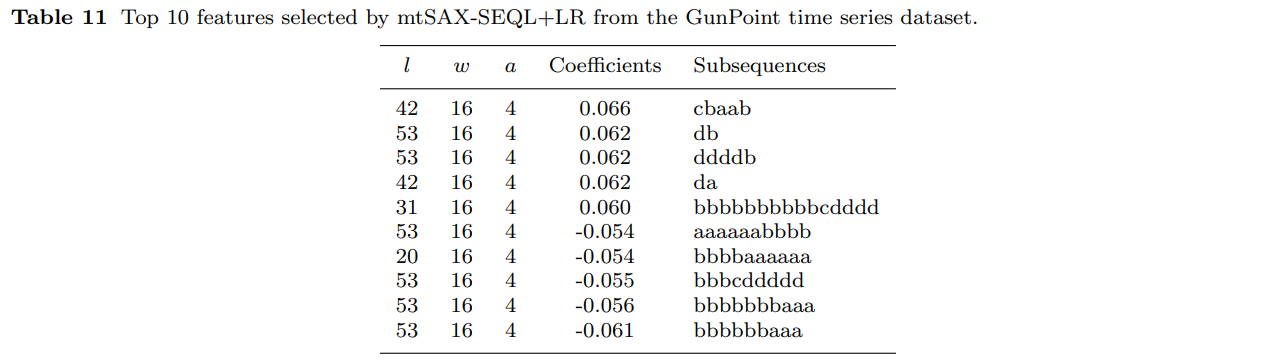

### Plot the discriminative regions

Inspired from https://github.com/lnthach/Mr-SEQL/blob/master/src/python/visual_timeseries.py


In the following `weighted_ts` designates the contribution of each point for the classification.

In [17]:
def compute_log_color(x):
	return (1.0/(1.0 + np.exp(-100*x)) - 0.5)*2

def compute_linewidth(x):
	return 1.0 + 4.0*x

def plot_thickness(ts, weighted_ts, label, ax=None):
	"""
	ts is the considered timeseries
	metats is the weighted timeseries
	"""
	if label == 0:
		weighted_ts = -weighted_ts

	weighted_ts = np.maximum(weighted_ts, 0)

	maxw = max(weighted_ts)
	# normalize the scores
	if maxw > 0:
		weighted_ts = weighted_ts / maxw
	lwa = np.array([compute_linewidth(x) for x in weighted_ts])
	# maxc = max(metats)
	# minc = min(metats)
	colormap = np.array([compute_log_color(x) for x in weighted_ts])

	for i in range(0,len(ts)-1):
		lw = (lwa[i] + lwa[i+1])/2
		color = (colormap[i]+colormap[i+1])/2
		if ax is None:
			plt.plot([i,i+1],ts[i:(i+2)],linewidth = lw,c=[color,0,max(0,0.8 - color)])
		else:
			ax.plot([i,i+1],ts[i:(i+2)],linewidth = lw,c=[color,0,max(0,0.8 - color)])

In [18]:
def get_weighted_ts(timeseries):
    """
    Adapted from `map_patterns` in https://github.com/sktime/sktime/blob/v0.8.1/sktime/classification/shapelet_based/mrseql/sax_converter.h

    Given a timeseries and its label, compute the contribution of each of its points for the classification.
    """     
    SAX_repr = dict()
    for l in list_l:
        list_word = timeseries2SAX(timeseries, l, w, paper_alphabet_order=False)
        SAX_repr[l] = list_word

    list_begin_ROI = []
    list_end_ROI = []
    list_coeffs = []

    for id_coeff in range(len(coeffs)):
        coeff = coeffs[id_coeff]
        num_l, num_seq = find_l(thresholds, id_coeff)
        seq = clf.sequences[num_l][num_seq].decode("utf-8") # sequence of interest
        l = list_l[num_l] # l of interest

        nb_occurrences = 0
        nb_locations = 0
        for cur_pos, word in enumerate(SAX_repr[l]):
            pos = 0
            while pos < w:
                pos = word.find(seq, pos)
                if pos == -1:
                    break

                else:
                    begin_ROI = cur_pos + pos * l / w
                    end_ROI = begin_ROI + len(seq) * l / w

                    begin_ROI = int(np.ceil(begin_ROI))
                    end_ROI = int(np.floor(end_ROI))

                    if begin_ROI>0:
                        begin_ROI -= 1

                    if end_ROI < L:
                        end_ROI += 1

                    list_begin_ROI.append(begin_ROI)
                    list_end_ROI.append(end_ROI)
                    nb_occurrences += 1
                    nb_locations += end_ROI-begin_ROI
                pos += 1

        for _ in range(nb_occurrences):
            list_coeffs.append(coeff/nb_locations)
                
    weighted_ts = np.zeros_like(timeseries)
    for begin_ROI, end_ROI, coeff in zip(list_begin_ROI, list_end_ROI, list_coeffs):
        weighted_ts[begin_ROI:end_ROI] += coeff
    
    return weighted_ts

In [19]:
def get_paper_weighted_ts(timeseries):
    """
    Given a timeseries and its label, compute the contribution of each of its points.
    It is done directly using a clf method (max_sax_model).
    """
    weighted_ts = clf.map_sax_model(timeseries)[0]
    return weighted_ts

Here we have a problem, even when following the c++ code to reimplement it in Python, we still have minor changes in the results

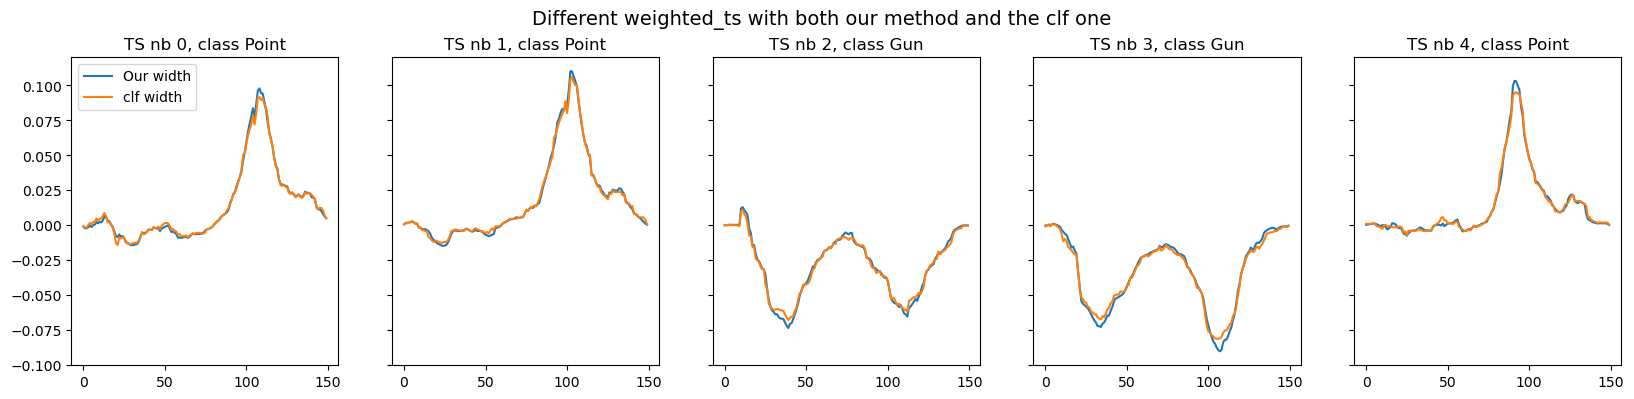

In [20]:
fig, ax = plt.subplots(1,5, figsize = (20,4), sharey=True)
for num_data in range(5):
    timeseries = X_train["dim_0"][num_data].to_numpy()
    label = label_dict[y_train[num_data]]
    weighted_ts = get_weighted_ts(timeseries)
    paper_weighted_ts = get_paper_weighted_ts(timeseries)
    ax[num_data].plot(weighted_ts, label="Our width")
    ax[num_data].plot(paper_weighted_ts, label="clf width")
    ax[num_data].set_title(f'TS nb {num_data}, class {class_dict[y_train[num_data]]}')
ax[0].legend()
plt.suptitle('Different weighted_ts with both our method and the clf one', fontsize=14, y=1)
plt.show()

However, when plotting the discriminative regions, one can't really see the difference (unless a little on the left of TS nb 4).

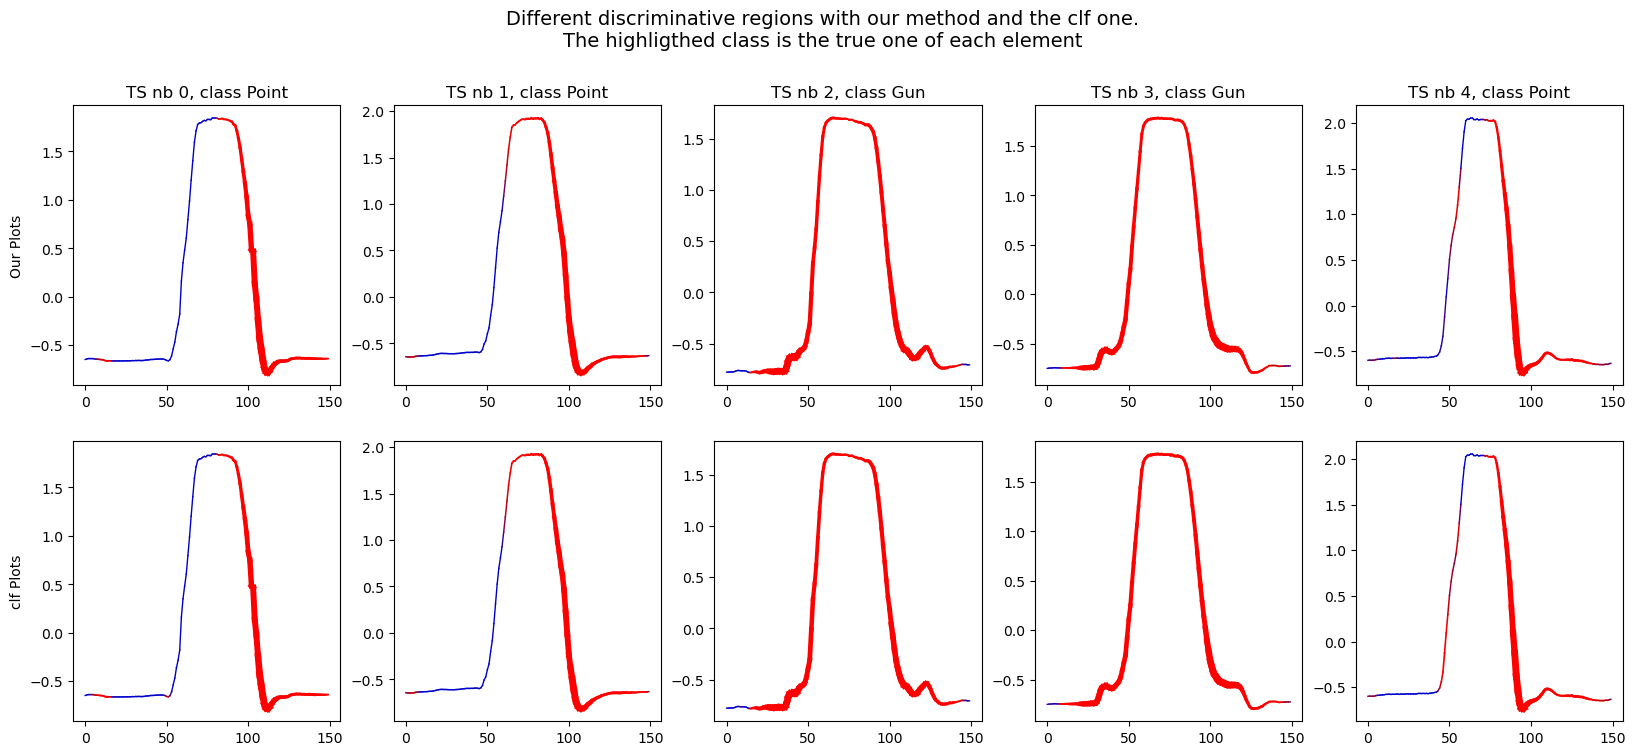

In [21]:
fig, ax = plt.subplots(2,5, figsize = (20,8))
for num_data in range(5):
    timeseries = X_train["dim_0"][num_data].to_numpy()
    label = label_dict[y_train[num_data]]
    weighted_ts = get_weighted_ts(timeseries)
    paper_weighted_ts = get_paper_weighted_ts(timeseries)

    plot_thickness(timeseries, weighted_ts, label,  ax=ax[0][num_data])
    plot_thickness(timeseries, paper_weighted_ts, label, ax=ax[1][num_data])
    ax[0][num_data].set_title(f'TS nb {num_data}, class {class_dict[y_train[num_data]]}')
    
ax[0][0].set_ylabel("Our Plots")
ax[1][0].set_ylabel("clf Plots")
plt.suptitle('Different discriminative regions with our method and the clf one.\nThe highligthed class is the true one of each element', fontsize=14, y=1)
plt.show()

One can see that for Point examples, the right hollow is pointed out, but for the Gun examples the left and right bump are more thickened than the rest of the TS (even if almost all of it is in red).

We can also compare them with the two examples given in the paper, and one can observe that we have pretty close curves (even if we had not the same best sequences and coefficients).

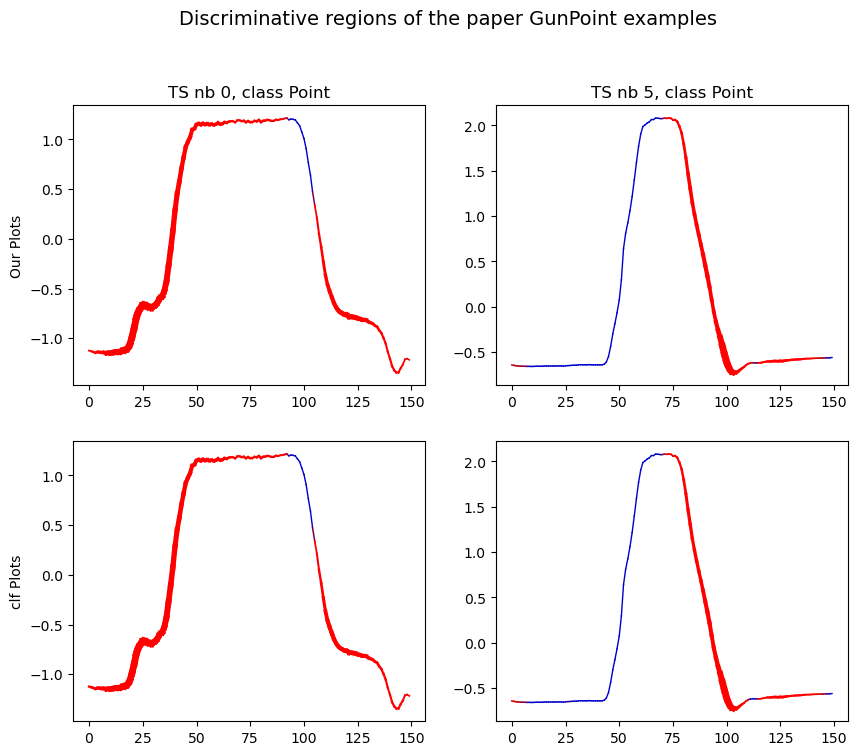

In [22]:
fig, ax = plt.subplots(2,2, figsize = (10,8))
for num_plot, num_data in enumerate([0,5]):
    timeseries = X_test["dim_0"][num_data].to_numpy()
    label = label_dict[y_test[num_data]]
    weighted_ts = get_weighted_ts(timeseries)
    paper_weighted_ts = get_paper_weighted_ts(timeseries)

    plot_thickness(timeseries, weighted_ts, label, ax=ax[0][num_plot])
    plot_thickness(timeseries, paper_weighted_ts, label, ax=ax[1][num_plot])
    ax[0][num_plot].set_title(f'TS nb {num_data}, class {class_dict[y_train[num_data]]}')
    
ax[0][0].set_ylabel("Our Plots")
ax[1][0].set_ylabel("clf Plots")
plt.suptitle(f'Discriminative regions of the paper {dataset_name} examples', fontsize=14, y=1)
plt.show()

To be compare with

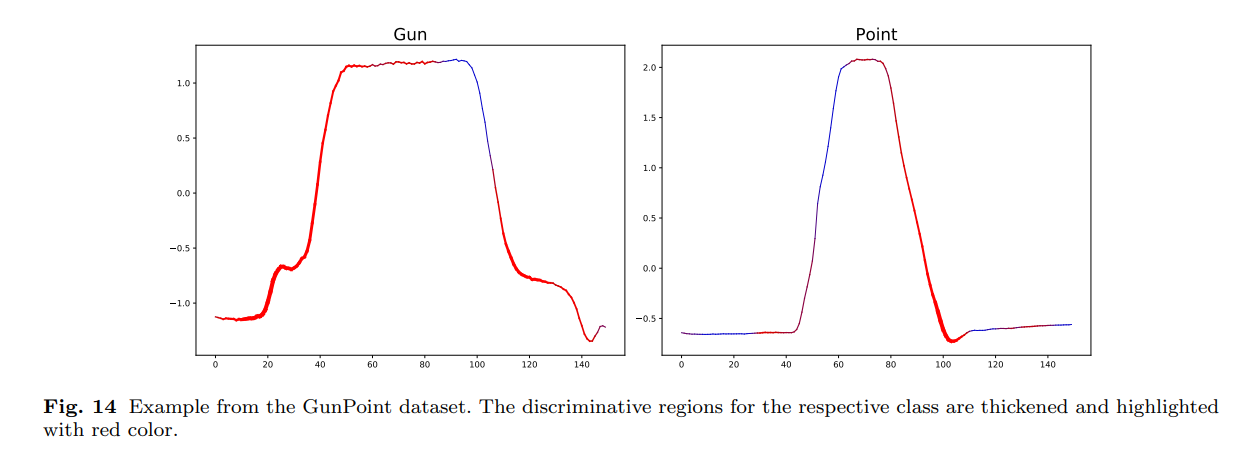

### Implementation warning:

Like we reimplemented it, and because there is no huge difference, we will use our implementation to compute the `weighted_ts` in the following.

## Coffee Dataset

We can also retrieve the paper example with the Coffee Dataset

### Data loading

In [23]:
dataset_name = "Coffee"

class_dict = {"0": "Arabica", "1": "Robusta"}
label_dict = {"0": 0, "1": 1}

X_train, y_train = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TRAIN.ts")
)
X_test, y_test = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TEST.ts")
)

### Set the config and train the classifier

In [24]:
L = X_train["dim_0"][0].shape[0]

w = 16

list_l = list(range(w, L, int(np.sqrt(L))))
# We retake the base rule of the article.
# In fact we don't need to specify a custom_config (it would be the same),
# but it is more convenient for the following

custom_config = []
for i in range(len(list_l)):
    custom_config.append({'method': 'sax', 'window': list_l[i], 'word': w, 'alphabet': alpha})

In [25]:
clf = MrSEQLClassifier(seql_mode="fs", symrep=('sax'), custom_config=custom_config)
clf.fit(X_train, y_train)
print(f"test score: {clf.score(X_test, y_test)}")

test score: 1.0


In [26]:
coeffs = clf.ots_clf.coef_[0]

thresholds = [0]
cum_sum = 0
for sequence_l in clf.sequences:
    cum_sum += len(sequence_l)
    thresholds.append(cum_sum)
print(thresholds)

[0, 61, 118, 171, 227, 278, 332, 389, 452, 510, 568, 622, 677, 735, 793, 843, 901, 947]


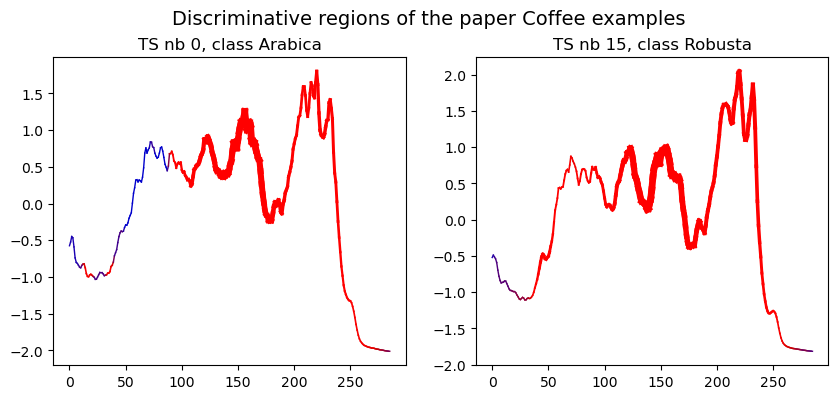

In [27]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for num_plot, num_data in enumerate([0,15]):
    timeseries = X_test["dim_0"][num_data].to_numpy()
    label = label_dict[y_test[num_data]]
    weighted_ts = get_weighted_ts(timeseries)

    plot_thickness(timeseries, weighted_ts, label, ax=ax[num_plot])
    ax[num_plot].set_title(f'TS nb {num_data}, class {class_dict[y_train[num_data]]}')
plt.suptitle(f'Discriminative regions of the paper {dataset_name} examples', fontsize=14, y=1)
plt.show()

To be compared with

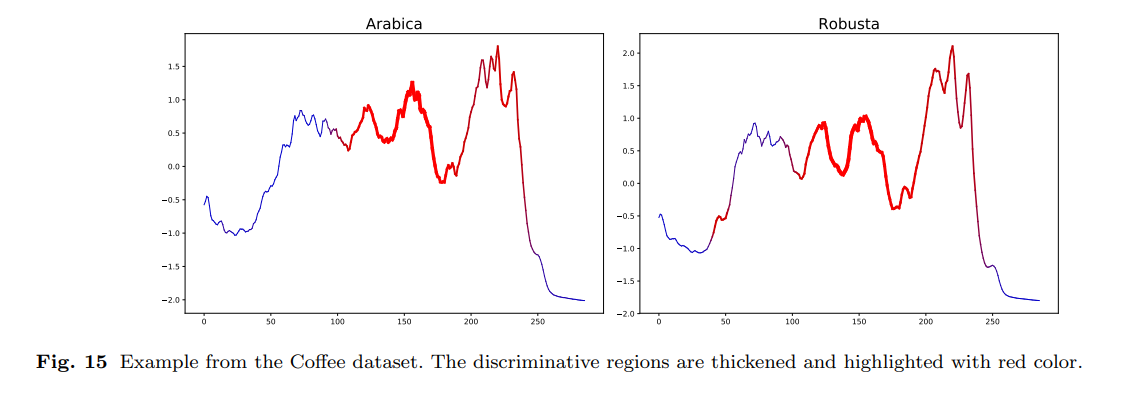

We observe some minor differences but maybe they didn't use the default list_l as they did for the GunPoint dataset.

## Application on another dataset not in the paper

Now that we have verified that we had the good SAX representation and that our plotting of the discriminative regions are good, we apply the method to another dataset not present in the article.

Here is the description of this datasetn named ``BirdChicken'':

``We have extracted the outlines of these images and mapped them into 1-D series of distances to the centre. Bird/Chicken is the problem of distinguishing between an outline of a bird and a chicken''.

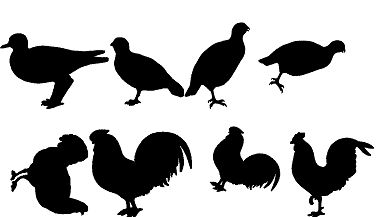


Before digging into applying our method, we can already try to guess the difference between the two classes: the Birds will have smoother curves and the Chickens rougher ones (especially because of their panaches).

### Data loading and examples

In [28]:
dataset_name = "BirdChicken"

class_dict = {"1": "Bird", "2": "Chicken"}
label_dict = {"1": 0, "2": 1}

X_train, y_train = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TRAIN.ts")
)
X_test, y_test = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TEST.ts")
)

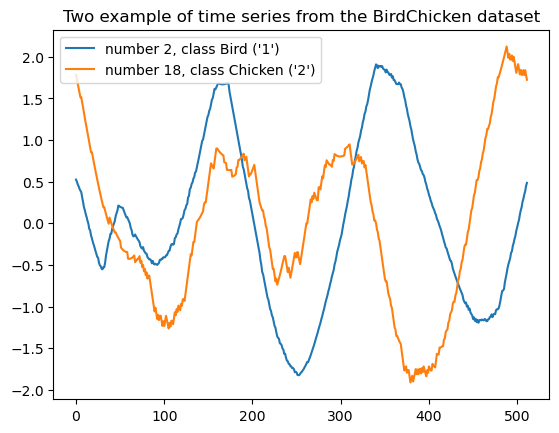

In [29]:
# An example of 2 Time Series from this dataset

i, j = 2, 18
plt.plot(X_train["dim_0"][i], label=f"number {i}, class {class_dict[y_train[i]]} ('{y_train[i]}')")
plt.plot(X_train["dim_0"][j], label=f"number {j}, class {class_dict[y_train[j]]} ('{y_train[j]}')")
plt.title(f"Two example of time series from the {dataset_name} dataset")
plt.legend()
plt.show()

As we can see, the Bird curve is smoother than the Chicken one.

### Check the data

Before applying the classifier, let's check if one of the hypothesis of the SAX symbolisation (the PAA values are normaly distributed) is verified.

In [30]:
def timeseries2PAA(timeseries, l, w):
    """
    Convert a timeseries to its PAA representation, given a window_lenght 'l' and a word size 'w'.
    'normalize' is the same parameters as in 'segment2SAX'
    """
    L = timeseries.shape[0]
    # PAA transform (and inverse transform) of the data
    all_list_PPA = []
    for cur_pos in range(L-l+1):
        sax_word, list_PPA, subsection = segment2SAX(timeseries, cur_pos, l, w, dupplicate_PAA=False)
        all_list_PPA += list(list_PPA)
    return all_list_PPA

In [31]:
list_l = list(range(w, L, int(np.sqrt(L))))

list_PPA_per_l = dict()

for l in list_l:
    all_list_PPA = []
    for num_data in range(len(X_train)):
        timeseries = X_train["dim_0"][num_data].to_numpy()
        all_list_PPA += timeseries2PAA(timeseries, l, w)
    
    list_PPA_per_l[l] = all_list_PPA

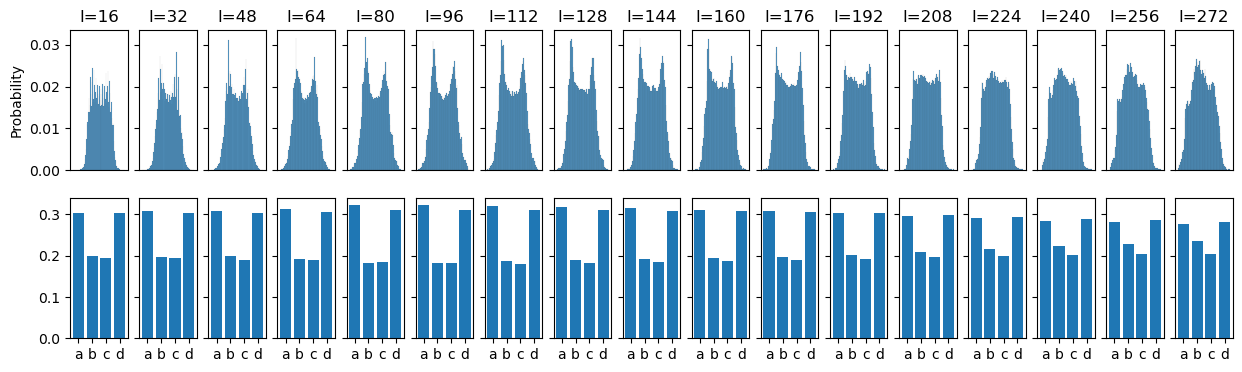

In [32]:
bins = [-4] + break_points + [4]
fig, ax = plt.subplots(2,len(list_l), figsize = (15,4), sharey='row')
for num_l, (l, all_list_PPA) in enumerate(list_PPA_per_l.items()):
    sns.histplot(all_list_PPA, ax=ax[0][num_l], stat="probability")
    ax[0][num_l].set_title(f"l={l}")
    ax[0][num_l].get_xaxis().set_ticks([])
    N, bins = np.histogram(all_list_PPA, bins=bins)
    ax[1][num_l].bar(["a", "b", "c", "d"], N / len(all_list_PPA))
    
plt.show()

We see that this hypothesis is not verified. However, this is not necessarily a too bad thing because it doesn't question the rest of the approach. Its shows that maybe another symbolisation after the PAA could be done, more data dependant (instead of just assuming a gaussian distribution).

We can also remark that, when `l` inreases, it diminishes this phenomena, which is not very surprising (the z-normalization is done on more points).

### Set the config and train the classifier

Now that we overlook the dataset, let's apply our method and see what our algorithm detect.

In [33]:
L = X_train["dim_0"][0].shape[0]

w = 16

custom_config = []
for i in range(len(list_l)):
    custom_config.append({'method': 'sax', 'window': list_l[i], 'word': w, 'alphabet': alpha})

In [34]:
clf = MrSEQLClassifier(seql_mode="fs", symrep=('sax'), custom_config=custom_config)
clf.fit(X_train, y_train)
print(f"test score: {clf.score(X_test, y_test)}")
Y_predict = clf.predict(X_test)

test score: 0.95


In [35]:
coeffs = clf.ots_clf.coef_[0]

thresholds = [0]
cum_sum = 0
for sequence_l in clf.sequences:
    cum_sum += len(sequence_l)
    thresholds.append(cum_sum)
print(thresholds)

[0, 68, 130, 183, 234, 287, 328, 385, 434, 483, 533, 579, 627, 672, 730, 771, 810, 861]


### Plotting some examples

We first find the mistake in the test set to show one.

In [36]:
num_data_mistake = None
for num_data in range(15):
    if Y_predict[num_data]!=y_test[num_data]:
        num_data_mistake = num_data
print(num_data_mistake)

6


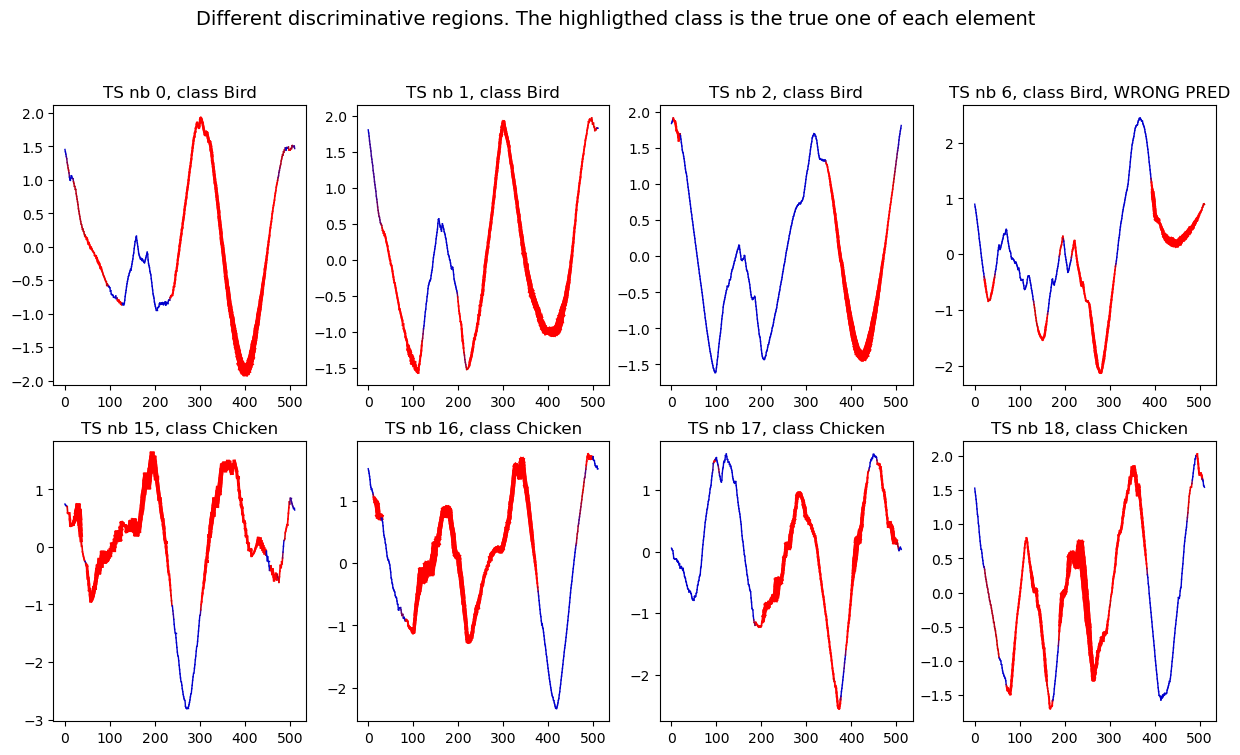

In [37]:
fig, ax = plt.subplots(2,4, figsize = (15,8))
for num_plot, num_data in enumerate([0, 1, 2, num_data_mistake]):
    timeseries = X_test["dim_0"][num_data].to_numpy()
    label = label_dict[y_test[num_data]]
    y_predict = Y_predict[num_data]
    weighted_ts = get_weighted_ts(timeseries)

    plot_thickness(timeseries, weighted_ts, label, ax=ax[0][num_plot])
    if y_predict == y_test[num_data]:
        ax[0][num_plot].set_title(f'TS nb {num_data}, class {class_dict[y_test[num_data]]}')
    else:
        ax[0][num_plot].set_title(f'TS nb {num_data}, class {class_dict[y_test[num_data]]}, WRONG PRED')


for num_plot, num_data in enumerate([15, 16, 17, 18]):
    timeseries = X_test["dim_0"][num_data].to_numpy()
    label = label_dict[y_test[num_data]]
    y_predict = Y_predict[num_data]
    weighted_ts = get_weighted_ts(timeseries)

    plot_thickness(timeseries, weighted_ts, label, ax=ax[1][num_plot])
    if y_predict == y_test[num_data]:
        ax[1][num_plot].set_title(f'TS nb {num_data}, class {class_dict[y_test[num_data]]}')
    else:
        ax[1][num_plot].set_title(f'TS nb {num_data}, class {class_dict[y_test[num_data]]}, WRONG PRED')

plt.suptitle('Different discriminative regions. The highligthed class is the true one of each element', fontsize=14, y=1)
plt.show()

We see that the algorithm has well understand that the smooth of the curve is important to classify the timeseries.

Howerver there is a wrong prediction. To better understand it, let's highlight the elements of the timeseries for both classes at the same time.

### Study of the mistake

In [38]:
def plot_green_thickness(ts,weighted_ts, label, ax=None):
	"""
	Similar to `plot_thickness`, but :
		- plot in green instead of red
		- doesn't plot null point
	It is use to hightlight the point of the other class in another color
	"""
	if label == 0:
		weighted_ts = -weighted_ts

	weighted_ts = np.maximum(weighted_ts, 0)

	maxw = max(weighted_ts)
	# normalize the scores
	if maxw > 0:
		weighted_ts = weighted_ts / maxw
	lwa = np.array([compute_linewidth(x) for x in weighted_ts])
	# maxc = max(metats)
	# minc = min(metats)
	colormap = np.array([compute_log_color(x) for x in weighted_ts])

	for i in range(0,len(ts)-1):
		lw = (lwa[i] + lwa[i+1])/2
		color = (colormap[i]+colormap[i+1])/2
		if color>0:
			if ax is None:
				plt.plot([i,i+1],ts[i:(i+2)],linewidth = lw,c=[0,color,max(0,0.8 - color)])
			else:
				ax.plot([i,i+1],ts[i:(i+2)],linewidth = lw,c=[0,color,max(0,0.8 - color)])

True class: Bird
Pred class: Chicken


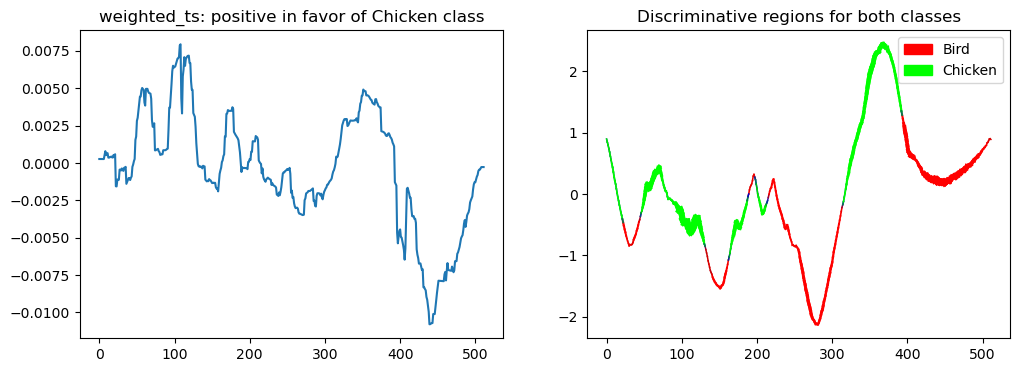

In [39]:
timeseries = X_test["dim_0"][num_data_mistake].to_numpy()
label = label_dict[y_test[num_data_mistake]]
pred_label = label_dict[Y_predict[num_data_mistake]]

weighted_ts = get_weighted_ts(timeseries)

print(f"True class: {class_dict[y_train[num_data_mistake]]}")
print(f"Pred class: {class_dict[Y_predict[num_data_mistake]]}")

fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].plot(weighted_ts)
ax[0].set_title(f"weighted_ts: positive in favor of Chicken class")
plot_thickness(timeseries, weighted_ts, label, ax=ax[1])
ax[1].set_title(f"Discriminative regions for both classes")
plot_green_thickness(timeseries, weighted_ts, pred_label, ax=ax[1])

red_patch = mpatches.Patch(color='red', label=f'{class_dict[y_train[num_data_mistake]]}')
green_patch = mpatches.Patch(color='lime', label=f'{class_dict[Y_predict[num_data_mistake]]}')
plt.legend(handles=[red_patch, green_patch])
plt.show()

Like expected, the algorithm predicts Chicken especially because of the pikes at the begining. Unfortunatly, we don't really know why the last bump is not in favor of Bird, because it seems quite smooth.

Another track would be the low hollow which is not so deep compareed to other Bird timeseries, but this is one of the biggest part in favor of this class.

### Analyse of the important sequences

In the following cells we find the most negative and positive sequences, and we reconstruct an artificial timeseries from them. The goal here is to study what kind of part they each represent. Obviously, the window size `l` associated to the sequence must be took into account (a larger `l` implies a longer reconstructed timeseries).

In [40]:
def SAX_to_TS(sequence, l):
    """
    Map each character of a sequence to a value, taking into account l and w
    to compute the length of the original timeseries represented by each character.
    """
    ts = []
    random_nb = np.random.random()/5 # this random part is to better show the different reconstructions
    for char in sequence:
        if char == "a":
            value = 0
        if char == "b":
            value = 1
        if char == "c":
            value = 2
        if char == "d":
            value = 3

        for _ in range(int(l/w)):
            ts.append(value + random_nb)
    return ts

In [41]:
nb_sequences_to_show = 20

## Get the most positive coefficient
sorted_pos_sequences_idx = coeffs.argsort()[::-1]

important_pos_sequences = []
important_pos_l = []

for ind in sorted_pos_sequences_idx[:nb_sequences_to_show//2]:
    coeff = coeffs[ind]
    num_l, num_seq = find_l(thresholds, ind)
    seq = clf.sequences[num_l][num_seq].decode("utf-8") # sequence of interest
    l = list_l[num_l] #l of interest

    important_pos_sequences.append(seq)
    important_pos_l.append(l)

    print(str(l).ljust(3), str("{:.5f}".format(coeff)).rjust(7), seq)

print()

## Get the most negative coefficient
sorted_neg_sequences_idx = coeffs.argsort()

important_neg_sequences = []
important_neg_l = []

for ind in sorted_neg_sequences_idx[:nb_sequences_to_show//2][::-1]:
    coeff = coeffs[ind]
    num_l, num_seq = find_l(thresholds, ind)
    seq = clf.sequences[num_l][num_seq].decode("utf-8") # sequence of interest
    l = list_l[num_l] #l of interest

    important_neg_sequences.append(seq)
    important_neg_l.append(l)

    print(str(l).ljust(3), str("{:.5f}".format(coeff)).rjust(8), seq)

48  0.01496 aaaaaabbcdddddd
48  0.01496 aaaaabbcdddddd
128 0.01487 dddbaa
128 0.01487 dddbaaa
128 0.01487 dddbaaaa
64  0.01474 aaaaabbcdddddd
16  0.01430 aaabbdddd
48  0.01412 aaaaaabccdddddd
128 0.01405 dddba
112 0.01405 dddb

64  -0.01613 ccbbaaaaabbcc
144 -0.01613 ddccbbaaaaaab
48  -0.01613 baaaaaabbbc
48  -0.01613 baaaaaabbbcc
48  -0.01613 baaaaaabbbccd
144 -0.01613 dccbbaaaaaab
96  -0.01613 bbaaaaabbbccddd
48  -0.01613 baaaaaabbbccddd
48  -0.01613 baaaaaabbbccdddd
96  -0.01613 bbaaaaabbbccdd


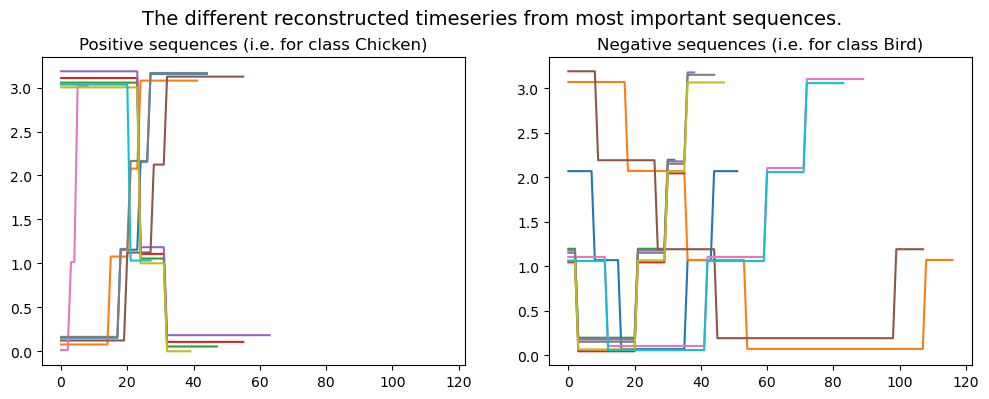

In [42]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharex=True)
for sequence, l in zip(important_pos_sequences, important_pos_l):
    ax[0].plot(SAX_to_TS(sequence, l), label=sequence)
ax[0].set_title("Positive sequences (i.e. for class Chicken)")

for sequence, l in zip(important_neg_sequences, important_neg_l):
    ax[1].plot(SAX_to_TS(sequence, l), label=sequence)
ax[1].set_title("Negative sequences (i.e. for class Bird)")

plt.suptitle('The different reconstructed timeseries from most important sequences.', fontsize=14, y=1)
plt.show()

We see that, once again, the sequences in favor in the Chicken class are the ones with high variations, whereas the ones for the Bird Class have relatively slow variations (and so represent smooother windows).

We can also plot the sum of all coefficient associated for each window size.

In [43]:
pos_l_coeffs = dict()
neg_l_coeffs = dict()

l_coeffs = dict()

for l in list_l:
    pos_l_coeffs[l] = 0
    neg_l_coeffs[l] = 0
    l_coeffs[l] = 0

for ind in range(len(coeffs)):
    coeff = coeffs[ind]
    num_l, num_seq = find_l(thresholds, ind)
    seq = clf.sequences[num_l][num_seq].decode("utf-8") # sequence of interest
    l = list_l[num_l] #l of interest
    if coeff > 0:
        pos_l_coeffs[l] += np.abs(coeff)
    else:
        neg_l_coeffs[l] += np.abs(coeff)

    l_coeffs[l] += coeff

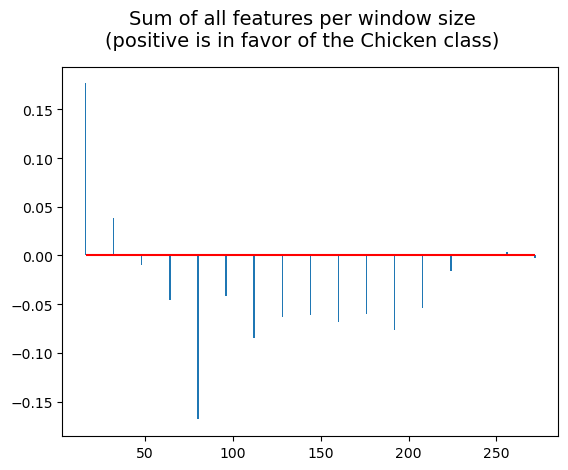

In [44]:
plt.bar(l_coeffs.keys(), l_coeffs.values())
plt.hlines(0, list(l_coeffs.keys())[0], list(l_coeffs.keys())[-1], colors='r')
plt.suptitle('Sum of all features per window size\n(positive is in favor of the Chicken class)', fontsize=14, y=1)
plt.show()

Once again, the low resolution sequence are more in favor of the positive class (Chicken), whereas the bigger resolution are in favor of the negativ class (Bird).

## Conclusion

To conclude this notebook, we reimplemented what we think are the most important things in the interpretation of the given model: the SAX representation and the plot of the discriminative regions.

This allowed, only with the coefficients (`clf.ots_clf`) and the associated sequences (`clf.sequences`) of the classifier, to analyse how it classified different timeseries: the `clf.map_sax_model` was only used to verify that we have the same convention, even if we don't have exactly the same results.


For the final part, even if there is one interrogation for the missclassified timeseries, we showed, with different manners, that the algorithm managed to detect well the differences between both classes, and that the use of different resolutions (i.e. window sizes `l`) is very useful for this algorithm. More precisely, in addition to the plots of the discriminative regions, we generated artifical timeseries to better understand the different sequences and grouped the coefficients per windows size.